In [10]:
import numpy as np
import os
import torch
from torch import optim
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
from sklearn import metrics
import pandas as pd
import nibabel as nb
from skimage.util import crop
from skimage.transform import resize
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
#from numba import cuda,jit
from MyCNN import MyNetwork
from AlexNet3D import AlexNet
from CustomCNNNetwork import CustomCNN
from sklearn.linear_model import Lasso, LinearRegression

In [11]:
mris = np.load('/data/users2/bthapaliya/BrainGNN/SLURMJobs/mris_test_file.npy')
ages = np.load('/data/users2/bthapaliya/BrainGNN/SLURMJobs/ages_test_file.npy')

In [12]:
mris.shape

(213, 96, 112, 96)

In [13]:
transformer = transforms.Compose([transforms.ToTensor()])

In [14]:
# number of subprocesses to use for data loading
num_workers = 4

X_test = torch.tensor(mris)
Y_test = torch.tensor(ages)
#print("done")
batch_size = 1

#n_feat = X_train.shape[1]
#print(X_train.shape)
#print(Y_train.shape)
# Train set
# Test set
testset = torch.utils.data.TensorDataset(X_test,Y_test)
testset = torch.utils.data.DataLoader(testset,batch_size=batch_size, num_workers=num_workers,shuffle=True,drop_last=True)


In [15]:
torch.cuda.empty_cache()
model = CustomCNN()
model.cuda()
model.load_state_dict(torch.load("/data/users2/bthapaliya/BrainGNN/SLURMJobs/customcnnoutputs/3lastepochmodel_epoch_100.pth"))
#model.eval()
#test_eval = model.eval(X_test, Y_test)

<All keys matched successfully>

In [16]:
predictions = torch.tensor([]).to('cuda')
actuals = torch.tensor([]).to('cuda')
with torch.no_grad():
        model.eval()
        for imgs,labels in testset:
            #if train_on_gpu:
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(torch.unsqueeze(imgs,1).float())
                #predictions.append(pred.int())
                #actuals.append(labels.int())
                predictions = torch.cat((predictions,pred),0)
                actuals = torch.cat((actuals,labels),0)

                


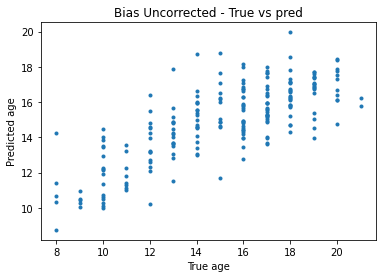

In [17]:
plt.figure()
plt.plot(actuals.detach().cpu().numpy(),predictions.detach().cpu().numpy(),'.')
plt.title('Bias Uncorrected - True vs pred')
plt.xlabel('True age')
plt.ylabel('Predicted age')
        
        # #writer.add_figure('Train - True vs pred', plt.gcf(),e,True)
        
        # plt.savefig('/data/users2/bthapaliya/BrainGNN/SLURMJobs/cnnoutputs/train_true_vs_pred.jpg',dpi=300)
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(actuals.detach().cpu().numpy(), predictions.detach().cpu().numpy())

1.72084

In [25]:
losses = np.load('/data/users2/bthapaliya/BrainGNN/SLURMJobs/customcnnoutputs/mainoutputs/train_losses1.npy')
losses_val = np.load('/data/users2/bthapaliya/BrainGNN/SLURMJobs/customcnnoutputs/mainoutputs/validation_losses1.npy')

In [26]:
num_epochs=100

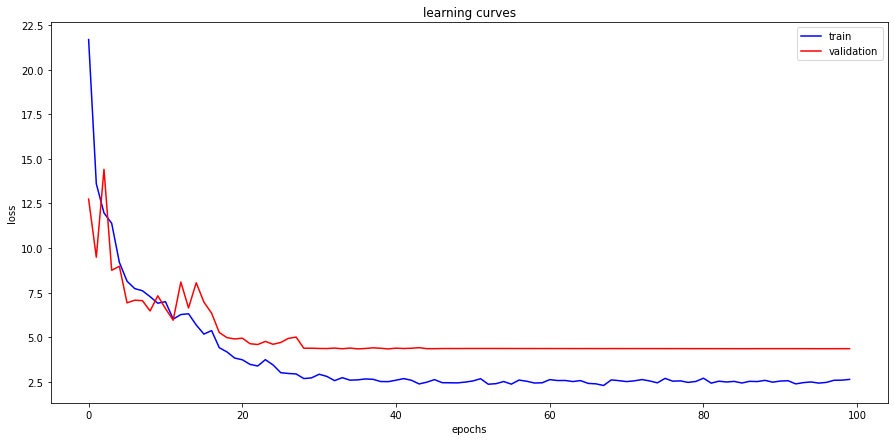

In [27]:
plt.figure(figsize=(15,7))
plt.plot(list(range(0,num_epochs)),losses,'b')
plt.plot(list(range(0,num_epochs)),losses_val,'r')
plt.title('learning curves')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
#plt.savefig('/data/users2/gdolci/CNN/plots/learning_curves.jpg',dpi=300)
plt.show()

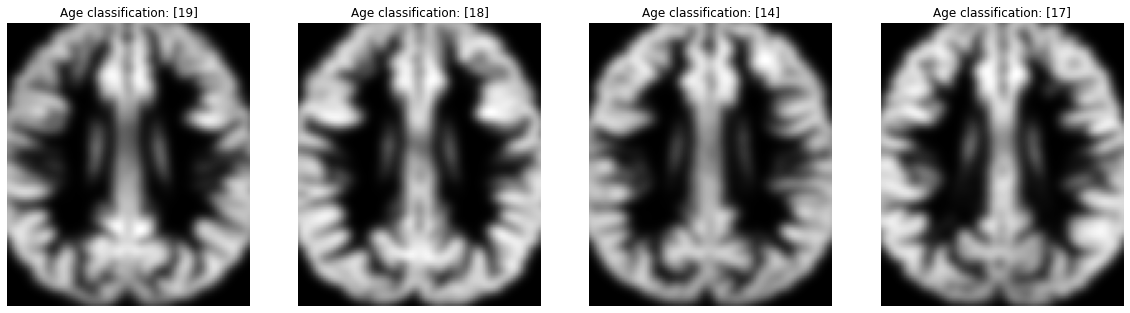

In [28]:
fig, axes = plt.subplots(1,4, figsize=(20,20))
for i in range(4):
  axes[i].imshow(X_test[i+5, :, :, 55].T, cmap='gray', origin='lower')
  axes[i].title.set_text("Age classification: {}".format(Y_test[i+5].detach().cpu().numpy()))
  axes[i].axis('off')
  plt.savefig("AllAgesBrain.png", dpi=300)


In [29]:
mris = np.load('/data/users2/bthapaliya/BrainGNN/SLURMJobs/mris_train_file.npy')
ages = np.load('/data/users2/bthapaliya/BrainGNN/SLURMJobs/ages_train_file.npy')

In [30]:
# number of subprocesses to use for data loading
num_workers = 4

X_train = torch.tensor(mris)
Y_train = torch.tensor(ages)
#print("done")
batch_size = 1

#n_feat = X_train.shape[1]
#print(X_train.shape)
#print(Y_train.shape)
# Train set
# Test set
trainset = torch.utils.data.TensorDataset(X_train,Y_train)
trainset = torch.utils.data.DataLoader(trainset,batch_size=batch_size, num_workers=num_workers,shuffle=True,drop_last=True)


In [31]:
train_predictions = torch.tensor([]).to('cuda')
train_actuals = torch.tensor([]).to('cuda')
with torch.no_grad():
        model.eval()
        for imgs,labels in trainset:
            #if train_on_gpu:
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(torch.unsqueeze(imgs,1).float())
                #predictions.append(pred.int())
                #actuals.append(labels.int())
                train_predictions = torch.cat((train_predictions,pred),0)
                train_actuals = torch.cat((train_actuals,labels),0)

                


In [32]:
yhat_train = train_predictions.detach().cpu().numpy()
y_train = train_actuals.detach().cpu().numpy()
bias = Lasso().fit(y_train, yhat_train)
# yhat_train = yhat_train.reshape(-1,)
# y_train = y_train.reshape(-1,)

alpha = bias.coef_[0]
intercept = bias.intercept_
corrected_age_train = yhat_train + \
(y_train - (alpha * y_train + intercept))

# yhat_test = model.predict(X_test)
# yhat_test = yhat_test.reshape(-1,)
#     corrected_age_test = yhat_test + (y_test - (alpha * y_test + intercept))
#corrected_age_train

In [33]:
test_predictions = predictions.detach().cpu().numpy()
test_actuals = actuals.detach().cpu().numpy()
test_actuals.shape

(213, 1)

In [34]:
#Delta Check
from scipy.stats import spearmanr


brain_age_delta = test_predictions - test_actuals
chronological_age = test_actuals

coef, p = spearmanr(brain_age_delta, chronological_age)


In [35]:
print(coef)

-0.7793496880779606


In [36]:
corrected_test_age = test_predictions + (test_actuals - (alpha * test_actuals + intercept))

In [37]:
brain_age_delta_new = corrected_test_age - test_actuals
coef_new, p_new = spearmanr(brain_age_delta_new, chronological_age)
print(coef_new)

-0.6006451579352111


In [38]:
corrected_test_age.shape

(213, 1)

In [39]:
test_predictions.shape

(213, 1)

In [40]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_actuals, test_predictions)

1.72084

In [41]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_actuals, corrected_test_age)

1.3193872

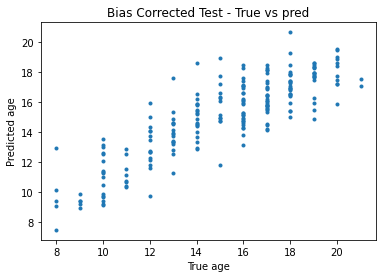

In [42]:
plt.figure()
plt.plot(test_actuals,corrected_test_age,'.')
plt.title('Bias Corrected Test - True vs pred')
plt.xlabel('True age')
plt.ylabel('Predicted age')
        
        # #writer.add_figure('Train - True vs pred', plt.gcf(),e,True)
        
        # plt.savefig('/data/users2/bthapaliya/BrainGNN/SLURMJobs/cnnoutputs/train_true_vs_pred.jpg',dpi=300)
plt.show()